In [1]:
%matplotlib inline
import pandas as pd
import pickle
from tqdm import tqdm
import numpy as np
import os
import scipy.stats as st
# import matplotlib.pyplot as plt
# import seaborn as sns
# import networkx as nx
# from scipy.cluster import hierarchy
# from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
# from scipy.spatial import distance

# from matplotlib.cm import get_cmap
# from matplotlib import gridspec
# import random

In [2]:
def input_paths(proj_path):

    input_paths_dict = {'QRZC_cids_inchi_smiles_path': proj_path + 'QRZC_drug_CIDs_inchi_smiles.csv',
                        'tool_path': proj_path + 'QRZC_activityStats_nooutliers_df_besttool.csv',
                        'L1000_gene_info_path': proj_path + 'GSE92742_Broad_LINCS_gene_info.txt',
                        'L1000_cell_info_path': proj_path + 'GSE92742_Broad_LINCS_cell_info.txt',
                        'L1000_inst_info_path': proj_path + 'GSE92742_Broad_LINCS_inst_info.txt',
                        'L1000_pert_info_path': proj_path + 'GSE92742_Broad_LINCS_pert_info.txt',
                        'L1000_sig_info_path': proj_path + 'GSE92742_Broad_LINCS_sig_info.txt',

                        'pos_edges_dict_path': proj_path + 'cell_pos_edges_dict_75.pickle',
                        'neg_edges_dict_path': proj_path + 'cell_neg_edges_dict_75.pickle',
                        'drugs_dict_path': proj_path + 'cell_drugs_dict_75.pickle',

                        'cgp_dir': proj_path + 'c2.cgp.v7.1.symbols.gmt',

                        'Enrichr_GEO_up_path': proj_path + 'Disease_Perturbations_from_GEO_up.txt',
                        'Enrichr_GEO_dn_path': proj_path + 'Disease_Perturbations_from_GEO_down.txt',

                        'TTD_drugs_path': proj_path + 'P1-02-TTD_drug_download.txt',
                        'TTD_InChI2CID_path': proj_path + 'TTD_drugs_InChI2CID.txt',
                        'TTD_drug_target_path': proj_path + 'P1-07-Drug-TargetMapping.csv',
                        'TTD_target_path': proj_path + 'P1-01-TTD_target_download.txt',
                        'MODZ_networks_path': proj_path + 'MODZ_networks/',
                        'CD_networks_path': proj_path + 'CD_networks/'}
    
    return input_paths_dict

In [3]:
def import_L1000_metadata(L1000_gene_info_path, L1000_cell_info_path, L1000_inst_info_path, L1000_pert_info_path, L1000_sig_info_path):

    L1000_gene_info = pd.read_csv(L1000_gene_info_path, sep='\t', low_memory=False)
    L1000_cell_info = pd.read_csv(L1000_cell_info_path, sep='\t', low_memory=False)
    L1000_inst_info = pd.read_csv(L1000_inst_info_path, sep='\t', low_memory=False)
    L1000_pert_info = pd.read_csv(L1000_pert_info_path, sep='\t', low_memory=False)
    L1000_sig_info = pd.read_csv(L1000_sig_info_path, sep='\t', low_memory=False)
    
    return L1000_gene_info, L1000_cell_info, L1000_inst_info, L1000_pert_info, L1000_sig_info

In [4]:
def process_QRZC_output(pos_edges_dict_path, neg_edges_dict_path, drugs_dict_path, L1000_gene_info):

    with open(pos_edges_dict_path, 'rb') as handle:
        cell_pos_edges_dict = pickle.load(handle)
    with open(neg_edges_dict_path, 'rb') as handle:
        cell_neg_edges_dict = pickle.load(handle)
    with open(drugs_dict_path, 'rb') as handle:
        cell_drugs_dict = pickle.load(handle)     
    
    edgelist_df_dict = {}
    nodelist_df_dict = {}
    for c in tqdm(cell_drugs_dict.keys(), position=0, leave=True):

        pos_edges_df = pd.DataFrame(np.array([(i, j) for i, j in zip(cell_drugs_dict[c], cell_pos_edges_dict[c])])).explode(1)
        neg_edges_df = pd.DataFrame(np.array([(i, j) for i, j in zip(cell_drugs_dict[c], cell_neg_edges_dict[c])])).explode(1)

        pos_edges_df = pos_edges_df[~pd.isnull(pos_edges_df[1])]
        neg_edges_df = neg_edges_df[~pd.isnull(neg_edges_df[1])]

        pos_edges_df = pos_edges_df.reset_index(drop=True).rename(columns={0: 'Drug', 1: 'Target'})
        neg_edges_df = neg_edges_df.reset_index(drop=True).rename(columns={0: 'Drug', 1: 'Target'})

        pos_edges_df['Target'] = pos_edges_df['Target'].astype(int)
        neg_edges_df['Target'] = neg_edges_df['Target'].astype(int)

        pos_edges_df['Direction'] = 'Up'
        neg_edges_df['Direction'] = 'Down'

        pos_edges_df = pd.merge(pos_edges_df, L1000_gene_info, left_on='Target', 
                                right_on='pr_gene_id', how='left')[['Drug', 'pr_gene_symbol', 'Direction']]
        neg_edges_df = pd.merge(neg_edges_df, L1000_gene_info, left_on='Target', 
                                right_on='pr_gene_id', how='left')[['Drug', 'pr_gene_symbol', 'Direction']]

        all_edges_df = pd.concat([pos_edges_df, neg_edges_df]).rename(columns={'pr_gene_symbol': 'Target'})

        if len(all_edges_df) > 0:
            edgelist_df_dict[c] = all_edges_df 

            nodelist_df_dict_drug = pd.DataFrame(columns=['Id', 'Label', 'Type'])
            nodelist_df_dict_drug['Id'] = edgelist_df_dict[c]['Drug'].unique()
            nodelist_df_dict_drug['Label'] = edgelist_df_dict[c]['Drug'].unique()
            nodelist_df_dict_drug['Type'] = 'Drug'
            nodelist_df_dict_target = pd.DataFrame(columns=['Id', 'Label', 'Type'])
            nodelist_df_dict_target['Id'] = edgelist_df_dict[c]['Target'].unique()
            nodelist_df_dict_target['Label'] = edgelist_df_dict[c]['Target'].unique()
            nodelist_df_dict_target['Type'] = 'Gene'

            nodelist_df_dict[c] = pd.concat([nodelist_df_dict_drug, nodelist_df_dict_target])


    allcells = pd.DataFrame(sorted(list(nodelist_df_dict.keys())), columns=['Cell_type'])
    allgenes = pd.DataFrame(sorted(list(set(pd.concat(nodelist_df_dict)[pd.concat(nodelist_df_dict)['Type']=='Gene']['Id']))), columns=['Gene_symbol'])
    alldrugs = pd.DataFrame(sorted(list(set(pd.concat(nodelist_df_dict)[pd.concat(nodelist_df_dict)['Type']=='Drug']['Id']))), columns=['Pert_iname'])

    allnodes = pd.DataFrame(columns=['Node_name'])
    allnodes['Node_name'] = np.concatenate([allgenes['Gene_symbol'].values, alldrugs['Pert_iname'].values])
    allnodes['Node_ID'] = allnodes.index.values
    
    return edgelist_df_dict, nodelist_df_dict, allcells, allgenes, alldrugs, allnodes

In [5]:
def import_CD_MODZ_networks(path):
    nodelist_df_dict = {}
    edgelist_df_dict = {}
    for f in os.listdir(path):
        if f.endswith('_nodes.csv'):
            nodelist_df_dict[f.split('_')[1]] = pd.read_csv(path + f)
            nodelist_df_dict[f.split('_')[1]] = nodelist_df_dict[f.split('_')[1]].rename(columns={'ID': 'Id'})
        elif f.endswith('_edges_dir.csv'):
            edgelist_df_dict[f.split('_')[1]] = pd.read_csv(path + f)
            edgelist_df_dict[f.split('_')[1]] = edgelist_df_dict[f.split('_')[1]].rename(columns={'pert_iname': 'Drug', 'gene_name': 'Target'})[['Drug', 'Target', 'Direction']]

    allcells = pd.DataFrame(sorted(list(nodelist_df_dict.keys())), columns=['Cell_type'])
    allgenes = pd.DataFrame(sorted(list(set(pd.concat(nodelist_df_dict)[pd.concat(nodelist_df_dict)['Type']=='Gene']['Id']))), 
                                columns=['Gene_symbol'])
    allgenes = allgenes.drop(0) # remove the row with gene name "-666", this is NA in Broad Institute convention
    alldrugs = pd.DataFrame(sorted(list(set(pd.concat(nodelist_df_dict)[pd.concat(nodelist_df_dict)['Type']=='Drug']['Id']))), 
                                columns=['Pert_iname'])

    allnodes = pd.DataFrame(columns=['Node_name'])
    allnodes['Node_name'] = np.concatenate([allgenes['Gene_symbol'].values, alldrugs['Pert_iname'].values])
    allnodes['Node_ID'] = allnodes.index.values
    
    return edgelist_df_dict, nodelist_df_dict, allcells, allgenes, alldrugs, allnodes

In [6]:
def process_MSigDB_CGP(cgp_dir):
    
    cgp = {}
    f = open(cgp_dir)
    for line in f:
        line = line.rstrip()
        cgp[line.split('http://')[0].split('\t')[0]] = line.split('http://')[1].split('\t')[1:]
    f.close()
        
    # identify the indices of the duplicates (after removing _UP and DN) to determine the genesets that have both _UP and _DN
    cgp_ix = pd.DataFrame(index=cgp.keys())
    cgp_ix = cgp_ix[(cgp_ix.index.str.endswith('_UP')) | (cgp_ix.index.str.endswith('_DN'))]
    cgp_ix = cgp_ix[cgp_ix.index.str[:-3].duplicated(keep=False)]

    # CGP dictionary with only the genesets with UP and DN
    cgp_updn = {i: cgp[i] for i in cgp_ix.index.values}
        
    cgp_updn_allgenes = set([j for i in cgp_updn.values() for j in i])
    cgp_updn_labels = sorted(list(set(cgp_ix.index.str[:-3])))
   
    return cgp_updn, cgp_updn_labels, cgp_updn_allgenes

In [7]:
def import_TDD(TTD_drugs_path, TTD_InChI2CID_path, TTD_drug_target_path, TTD_target_path):
    
    TTD_drugs = pd.read_csv(TTD_drugs_path, sep='\t', skiprows=29)
    TTD_InChI2CID = pd.read_csv(TTD_InChI2CID_path, sep='\t', header=None)
    TTD_drugs_CID = pd.merge(TTD_drugs[TTD_drugs['DRUG__ID']=='DRUGINKE'], TTD_InChI2CID, left_on='D00AAN.1', right_on=0)
    TTD_drug_target = pd.read_csv(TTD_drug_target_path)

    f = open(TTD_target_path, 'r')
    TTD_targID_dict = {}
    for line in f:
        line = line.split('\t')
        if len(line) == 3:
            if line[1] == 'GENENAME':
                TTD_targID_dict[line[2].strip('\n')] = line[0]
    f.close()
    
    return TTD_drugs, TTD_InChI2CID, TTD_drugs_CID, TTD_drug_target, TTD_targID_dict

In [8]:
def get_geneset_targets(geneset_up, geneset_dn, TTD_targID_dict, TTD_drug_target, TTD_drugs_CID, pert_iname2CID):

    # getting the direct targets of the input geneset from TTD
    geneset_targetIDs = [TTD_targID_dict[i] for i in list(set(TTD_targID_dict.keys()) & (geneset_dn | geneset_up))]
    geneset_drugID_targetID = TTD_drug_target[TTD_drug_target['TargetID'].isin(geneset_targetIDs)]
    geneset_drugCIDs = TTD_drugs_CID[TTD_drugs_CID['D00AAN'].isin(geneset_drugID_targetID['DrugID'])]
    geneset_drugID_targetCID = pd.merge(geneset_drugID_targetID, geneset_drugCIDs, left_on='DrugID', right_on='D00AAN', how='left')


    # Get the subset of drugs targeting the given pathway above that is within the QRZC drugs by
    # (1) first getting the lookup table between CIDs, InCHI Keys, SMILES and pert_inames of QRZC compounds;
    # (2) then subsetting the drugs targeting the given pathway by the ones that are in QRZC, in terms of their pert_inames.
    # The resulting number of compounds is naturally small since the drugs in QRZC networks are a small subset of all the drugs 
    # in the TTD database.

    geneset_targets_pert_iname = pd.merge(geneset_drugID_targetCID, pert_iname2CID, 
                                                    left_on=1, right_on='pubchem_cid_x', how='left')
    geneset_targets_pert_iname = geneset_targets_pert_iname[~pd.isnull(geneset_targets_pert_iname['Pert_iname'])]

    return set(geneset_targets_pert_iname['Pert_iname'])

In [9]:
def get_MSigDB_geneset_targets(cgp_updn_labels, cgp_updn, TTD_targID_dict, TTD_drug_target, TTD_drugs_CID, pert_iname2CID):
    
    geneset_pert_iname_dict = {}
    for geneset_name in tqdm(cgp_updn_labels, position=0, leave=True):

        geneset_up = set(cgp_updn[geneset_name + '_UP'])
        geneset_dn = set(cgp_updn[geneset_name + '_DN'])        
        geneset_pert_iname_dict[geneset_name] = get_geneset_targets(geneset_up, geneset_dn, TTD_targID_dict, TTD_drug_target, 
                                                                         TTD_drugs_CID, pert_iname2CID)
        
    return geneset_pert_iname_dict

In [10]:
def import_Enrichr_GEO(Enrichr_GEO_up_path, Enrichr_GEO_dn_path):

    Enrichr_GEO_disease_human_up = {}
    f = open(Enrichr_GEO_up_path)
    for line in f:
        line = line.rstrip()
        d = line.split('\t')[0]
        g = line.split('\t')[2:]
        if 'human' in d:
            Enrichr_GEO_disease_human_up[d] = g       
    f.close()

    Enrichr_GEO_disease_human_dn = {}
    f = open(Enrichr_GEO_dn_path)
    for line in f:
        line = line.rstrip()
        d = line.split('\t')[0]
        g = line.split('\t')[2:]
        if 'human' in d:
            Enrichr_GEO_disease_human_dn[d] = g       
    f.close()
    
    return Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn

In [11]:
# Calculate the Signature Congruity Score (SCS) between two genesets, typically an input signature (or perturbation) and a disease signature.
def SCS(geneset_up, geneset_dn, disease_up, disease_dn):
        
        if len((geneset_up | geneset_dn) & (disease_up | disease_dn)) > 0:
            SCS_g_d = 1.0 * ((len(disease_up & geneset_up) + len(disease_dn & geneset_dn) 
                       - len(disease_dn & geneset_up) - len(disease_up & geneset_dn)) / len(disease_up | disease_dn))
            return SCS_g_d
        else:
            return np.nan        

In [12]:
def PCP_geneset(geneset_up, geneset_dn, disease_sig_up_dict, disease_sig_dn_dict, geneset_name='Geneset'):

    PCP_geneset_df = pd.DataFrame(index=[geneset_name], columns=sorted(disease_sig_up_dict.keys()), dtype='float')
    
    for d in disease_sig_up_dict.keys():
        disease_up = set(disease_sig_up_dict[d])
        disease_dn = set(disease_sig_dn_dict[d])    
        
        PCP_geneset_df.at[geneset_name, d] = SCS(geneset_up, geneset_dn, disease_up, disease_dn)
        
    return PCP_geneset_df

In [13]:
def PCP_geneset_allMsigDB(cgp_updn, cgp_updn_labels, disease_sig_up_dict, disease_sig_dn_dict):
    
    PCP_geneset_allMsigDB_df = pd.DataFrame(index=cgp_updn_labels, columns=sorted(disease_sig_up_dict.keys()), dtype='float')
        
    for geneset_name in tqdm(cgp_updn_labels, position=0, leave=True):
        geneset_up = set(cgp_updn[geneset_name + '_UP'])
        geneset_dn = set(cgp_updn[geneset_name + '_DN'])        
        
        for d in disease_sig_up_dict.keys():
            disease_up = set(disease_sig_up_dict[d])
            disease_dn = set(disease_sig_dn_dict[d])    

            PCP_geneset_allMsigDB_df.at[geneset_name, d] = SCS(geneset_up, geneset_dn, disease_up, disease_dn)
            
    return PCP_geneset_allMsigDB_df    

In [14]:
def PCP_perturbation(perturbation, allcells, edgelist_df_dict, disease_sig_up_dict, disease_sig_dn_dict):

    PCP_perturbation_df = pd.DataFrame(index=allcells['Cell_type'], columns=sorted(disease_sig_up_dict.keys()), dtype='float')
    
    for c in allcells['Cell_type']:

        cell_drugs = sorted(list(set(edgelist_df_dict[c]['Drug'])))

        if perturbation in cell_drugs:

            cell_sorted_df = edgelist_df_dict[c].sort_values(['Drug', 'Target']) 
            drug_up = set(cell_sorted_df[(cell_sorted_df['Drug']==perturbation) & (cell_sorted_df['Direction']=='Up')]['Target'].values)
            drug_dn = set(cell_sorted_df[(cell_sorted_df['Drug']==perturbation) & (cell_sorted_df['Direction']=='Down')]['Target'].values)

            for d in disease_sig_up_dict.keys():
                disease_up = set(disease_sig_up_dict[d])
                disease_dn = set(disease_sig_dn_dict[d])    

                PCP_perturbation_df.at[c, d] = SCS(drug_up, drug_dn, disease_up, disease_dn)

        else:
            PCP_perturbation_df = PCP_perturbation_df.drop(c)
            
    return PCP_perturbation_df

In [15]:
def PCP_perturbation_alldrugs(alldrugs, allcells, edgelist_df_dict, disease_sig_up_dict, disease_sig_dn_dict, 
                              proj_path, method_name, return_output=False):
    
    if not os.path.exists(proj_path + method_name + '_pcp_perturbation_df_dict.pickle'):
        
        print('Calculating PCPs for all perturbations...', flush=True)
        PCP_perturbation_df_dict = {}

        for drug in tqdm(alldrugs['Pert_iname'], position=0, leave=True):

            PCP_perturbation_df_dict[drug] = PCP_perturbation(drug, allcells, edgelist_df_dict, disease_sig_up_dict, disease_sig_dn_dict)

        with open(proj_path + method_name + '_pcp_perturbation_df_dict.pickle', 'wb') as fp:
            pickle.dump(PCP_perturbation_df_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
            
        if return_output==True:  
            return PCP_perturbation_df_dict
                
    else:
        
        print('Reading PCPs for all perturbations...', flush=True)
        with open(proj_path + method_name + '_pcp_perturbation_df_dict.pickle', 'rb') as fp:
            PCP_perturbation_df_dict = pickle.load(fp)      
    
        if return_output==True:  
            return PCP_perturbation_df_dict

In [16]:
def calculate_auroc(TPR, FPR):
    
    dTPR = np.concatenate((np.ediff1d(TPR), [0]))
    dFPR = np.concatenate((np.ediff1d(FPR), [0]))
    
    return sum(TPR * dFPR) + sum(dTPR * dFPR)/2

In [17]:
def AUROC_AUPRC(ranked_array, positives, auc_threshold=5, binsize=1):

    ranked_array_positives = set(ranked_array) & positives                 
    
    if len(ranked_array_positives) >= auc_threshold:
        
        bins = np.arange(1, len(ranked_array), binsize)      
        TPR = np.zeros(len(bins))
        FPR = np.zeros(len(bins))
        precision = np.zeros(len(bins))
        recall = np.zeros(len(bins))    

        for i, n in enumerate(bins):

            topN = ranked_array[0:n]

            overlap = set(topN) & ranked_array_positives

            TP = 1.0 * len(overlap)
            FP = len(topN) - TP
            FN = len(ranked_array_positives) - TP
            TN = len(ranked_array) - (TP + FP + FN)
            TPR[i] = TP / (TP + FN)
            FPR[i] = FP / (FP + TN)
            precision[i] = TP / (TP + FP)
            recall[i] = TP / (TP + FN)

        auroc = calculate_auroc(TPR, FPR)
        auprc = calculate_auroc(precision, recall)
    
        return auroc, auprc
    
    else:
        return np.nan, np.nan

In [18]:
def PACOS(PCP_geneset_df, PCP_perturbation_df_dict, alldrugs, allcells, tool_scores, 
          proj_path, method_name, geneset_name, r=2.0, threshold=10, tqdm_off=False, messages=False):

    if not os.path.exists(proj_path +  '%s_%s_r%s.csv' % (method_name, geneset_name, int(r))):
        
        if messages: print('Running Pathopticon...', flush=True)
        PACOS_spearman_rho_df = pd.DataFrame(index=alldrugs['Pert_iname'], columns=allcells['Cell_type'], dtype='float')
        PACOS_spearman_pval_df = pd.DataFrame(index=alldrugs['Pert_iname'], columns=allcells['Cell_type'], dtype='float')
        
        for drug in tqdm(alldrugs['Pert_iname'], position=0, leave=True, disable=tqdm_off):

            for c in PCP_perturbation_df_dict[drug].index:
                common_diseases = set(PCP_geneset_df.loc[geneset_name][~pd.isnull(PCP_geneset_df.loc[geneset_name])].index) &\
                                    set(PCP_perturbation_df_dict[drug].loc[c][~pd.isnull(PCP_perturbation_df_dict[drug].loc[c])].index)
                if len(common_diseases) >= threshold:
                    PACOS_spearman_rho_df.at[drug, c], PACOS_spearman_pval_df.at[drug, c] = st.spearmanr(PCP_geneset_df.loc[geneset_name][common_diseases], 
                                                                      PCP_perturbation_df_dict[drug].loc[c][common_diseases])

        PACOS_spearman_rho_df[pd.isnull(PACOS_spearman_rho_df)] = -666
        sorted_ix = np.argsort(PACOS_spearman_rho_df.values.flatten())
        nonan_len = len(PACOS_spearman_rho_df.values.flatten()[PACOS_spearman_rho_df.values.flatten()!=-666])
        nonan_ranked = PACOS_spearman_rho_df.values.flatten()[np.flip(sorted_ix)[0:nonan_len]]
        nonan_ranked_ix = np.flip(sorted_ix)[0:nonan_len]
        nonan_ranked_i, nonan_ranked_j = np.unravel_index(nonan_ranked_ix, PACOS_spearman_rho_df.shape)

        PACOS_spearman_rho_all_ranked = pd.DataFrame()
        PACOS_spearman_rho_all_ranked['Pert_iname'] = PACOS_spearman_rho_df.index[nonan_ranked_i]
        PACOS_spearman_rho_all_ranked['Cell_type'] = PACOS_spearman_rho_df.columns[nonan_ranked_j]
        PACOS_spearman_rho_all_ranked['PACOS_Spearman_rho'] = np.array([PACOS_spearman_rho_df.at[PACOS_spearman_rho_df.index[i], 
                                                                                                 PACOS_spearman_rho_df.columns[j]] 
                                                                        for i, j in zip(nonan_ranked_i, nonan_ranked_j)])
        PACOS_spearman_rho_all_ranked['PACOS_Spearman_pval'] = np.array([PACOS_spearman_pval_df.at[PACOS_spearman_rho_df.index[i], 
                                                                                                   PACOS_spearman_rho_df.columns[j]] 
                                                                        for i, j in zip(nonan_ranked_i, nonan_ranked_j)]) 


        PACOS_tool_merged_df = pd.merge(PACOS_spearman_rho_all_ranked, tool_scores, left_on='Pert_iname', right_on='Pert_iname', how='left')
        PACOS_tool_merged_df['PACOS_Spearman_rho_reverse'] = -1.0*PACOS_tool_merged_df['PACOS_Spearman_rho']
        PACOS_tool_merged_df['tool_score_imputed'] = PACOS_tool_merged_df['tool score scaled'].fillna(tool_scores['tool score scaled'].median())   
        PACOS_tool_merged_df['PACOS_tool_combined'] = (r*PACOS_tool_merged_df['PACOS_Spearman_rho'] + 
                                                       PACOS_tool_merged_df['tool_score_imputed']) / (r + 1.0)
        PACOS_tool_merged_df['PACOS_tool_combined_reverse'] = (-1.0*r*PACOS_tool_merged_df['PACOS_Spearman_rho'] + 
                                                       PACOS_tool_merged_df['tool_score_imputed']) / (r + 1.0)


        PACOS_tool_merged_df.to_csv(proj_path +  '%s_%s_r%s.csv' % (method_name, geneset_name, int(r)), index=False)
        
        return PACOS_tool_merged_df
        
    else:
        
        PACOS_tool_merged_df = pd.read_csv(proj_path +  '%s_%s_r%s.csv' % (method_name, geneset_name, int(r)))
        
        return PACOS_tool_merged_df

In [19]:
def PACOS_cell_AUC(PACOS_tool_merged_df, allcells, positives, 
                   models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'PACOS_tool_combined', 'PACOS_tool_combined_reverse'],
                   auc_params={'auc_threshold':5, 'binsize':1}):
    
    model_auroc_df = pd.DataFrame(index=allcells['Cell_type'], columns=['%s_AUROC' % m for m in models])
    model_auprc_df = pd.DataFrame(index=allcells['Cell_type'], columns=['%s_AUPRC' % m for m in models])
    
    for m in models:
        
        allcells_sorted = PACOS_tool_merged_df.sort_values(['Cell_type', m], ascending=[True, False])
        
        for c in allcells['Cell_type']:  
            cell_sorted = allcells_sorted[allcells_sorted['Cell_type']==c]['Pert_iname'].values
            model_auroc_df.at[c, '%s_AUROC' % m], model_auprc_df.at[c, '%s_AUPRC' % m] = AUROC_AUPRC(cell_sorted, positives, 
                                                                                                                   auc_threshold=auc_params['auc_threshold'], 
                                                                                                                   binsize=auc_params['binsize'])
        
    return model_auroc_df, model_auprc_df

In [20]:
def PACOS_cell_AUC_randomize(PACOS_tool_merged_df, allcells, positives, 
                             models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'PACOS_tool_combined', 'PACOS_tool_combined_reverse'],
                             auc_params={'auc_threshold':5, 'binsize':1}, 
                             Nrand=200, tqdm_off=False):

    rand_model_auroc_df_dict = {}
    rand_model_auprc_df_dict = {}
    
    for m in models:
        
        cell_geneset_auroc_df = pd.DataFrame(index=allcells['Cell_type'], columns=np.arange(Nrand))
        cell_geneset_auprc_df = pd.DataFrame(index=allcells['Cell_type'], columns=np.arange(Nrand))        

        allcells_sorted = PACOS_tool_merged_df.sort_values(['Cell_type', m], ascending=[True, False])
        
        for nrand in tqdm(np.arange(Nrand), position=0, leave=True, disable=tqdm_off):
            for c in allcells['Cell_type']:  
                cell_sorted = allcells_sorted[allcells_sorted['Cell_type']==c]['Pert_iname'].values
                np.random.shuffle(cell_sorted)
                cell_geneset_auroc_df.at[c, nrand], cell_geneset_auprc_df.at[c, nrand] = AUROC_AUPRC(cell_sorted, positives, 
                                                                                                     auc_threshold=auc_params['auc_threshold'], 
                                                                                                     binsize=auc_params['binsize'])
            
        rand_model_auroc_df_dict[m] = cell_geneset_auroc_df
        rand_model_auprc_df_dict[m] = cell_geneset_auprc_df 
        
    return rand_model_auroc_df_dict, rand_model_auprc_df_dict

In [21]:
def PACOS_nested_prioritization(PACOS_tool_merged_df, model_auroc_df, rand_model_auroc_df_dict):
    
    emp_pval_df = pd.DataFrame(index=model_auroc_df.index, columns=['%s_AUROC_emp_pval' % m for m in list(rand_model_auroc_df_dict.keys())])
    
    for m in rand_model_auroc_df_dict.keys():
    
        nonan_cells = model_auroc_df['%s_AUROC' % m][~pd.isnull(model_auroc_df['%s_AUROC' % m])].index
        for c in nonan_cells:
            emp_pval_df.at[c, '%s_AUROC_emp_pval' % m] = ((rand_model_auroc_df_dict[m].loc[c].values > 
                                                             model_auroc_df['%s_AUROC' % m].loc[c]).sum() /
                                                            float(np.shape(rand_model_auroc_df_dict[m])[1]))
    
    model_auroc_pval_df = pd.merge(model_auroc_df, emp_pval_df, left_index=True, right_index=True)
    PACOS_nested_df = pd.merge(PACOS_tool_merged_df, model_auroc_pval_df, left_on='Cell_type', 
                               right_index=True).dropna(subset=['%s_AUROC' % m for m in list(rand_model_auroc_df_dict.keys())])        
        
    return emp_pval_df, PACOS_nested_df

In [22]:
def run_benchmark(proj_path, proj_output_path, benchmark_path, method_name, 
                  PACOS_Spearman_threshold=10, r=2.0,  Nrand=100, auc_params={'auc_threshold':5, 'binsize':1}, 
                  models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'PACOS_tool_combined', 'PACOS_tool_combined_reverse']):
    
    print('Loading input data...', flush=True)
    input_paths_dict = input_paths(proj_path)
    
    L1000_gene_info, L1000_cell_info, L1000_inst_info, L1000_pert_info, L1000_sig_info = import_L1000_metadata(input_paths_dict['L1000_gene_info_path'], 
                                                                                                               input_paths_dict['L1000_cell_info_path'],
                                                                                                               input_paths_dict['L1000_inst_info_path'], 
                                                                                                               input_paths_dict['L1000_pert_info_path'], 
                                                                                                               input_paths_dict['L1000_sig_info_path'])    
    
    QUIZC_cids_inchi_smiles = pd.read_csv(input_paths_dict['QRZC_cids_inchi_smiles_path'])
    QUIZC_activityStats_nooutliers_df_besttool = pd.read_csv(input_paths_dict['tool_path'])
        
    cgp_updn, cgp_updn_labels, cgp_updn_allgenes = process_MSigDB_CGP(input_paths_dict['cgp_dir'])
    Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn = import_Enrichr_GEO(input_paths_dict['Enrichr_GEO_up_path'], 
                                                                                    input_paths_dict['Enrichr_GEO_dn_path'])
    TTD_drugs, TTD_InChI2CID, TTD_drugs_CID, TTD_drug_target, TTD_targID_dict = import_TDD(input_paths_dict['TTD_drugs_path'], 
                                                                                           input_paths_dict['TTD_InChI2CID_path'],
                                                                                           input_paths_dict['TTD_drug_target_path'], 
                                                                                           input_paths_dict['TTD_target_path'])

    geneset_pert_iname_dict = get_MSigDB_geneset_targets(cgp_updn_labels, cgp_updn, TTD_targID_dict, TTD_drug_target, 
                                                         TTD_drugs_CID, QUIZC_cids_inchi_smiles)   
    
    
    if method_name == 'QUIZ-C':
        print('Processing QUIZ-C networks...', flush=True)
        edgelist_df_dict, nodelist_df_dict, allcells, allgenes, alldrugs, allnodes = process_QRZC_output(input_paths_dict['pos_edges_dict_path'], 
                                                                                                         input_paths_dict['neg_edges_dict_path'],
                                                                                                         input_paths_dict['drugs_dict_path'],
                                                                                                         L1000_gene_info)
    elif (method_name == 'MODZ') | (method_name == 'CD'):
        print('Importing gene-perturbation networks...', flush=True)
        edgelist_df_dict, nodelist_df_dict, allcells, allgenes, alldrugs, allnodes = import_CD_MODZ_networks(input_paths_dict['%s_networks_path' % method_name])  

    
    pcp_perturbation_df_dict = PCP_perturbation_alldrugs(alldrugs, allcells, edgelist_df_dict, 
                                                         Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn,
                                                         proj_output_path, method_name=method_name, return_output=True) 
                                                                                                               
    print('Calculating PCPs for all benchmark gene sets...', flush=True)                                                                                                                
    pcp_geneset_allMsigDB_df = PCP_geneset_allMsigDB(cgp_updn, cgp_updn_labels, Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn)
    
    
    print('Running the benchmark...', flush=True)      
    benchmark_genesets = pd.read_csv(proj_path + 'benchmark_genesets.csv', header=None).rename(columns={0: 'Geneset_name'})
                                                                                                               
    for geneset_name in tqdm(benchmark_genesets['Geneset_name'].to_numpy(), position=0, leave=True):
        
        if not os.path.exists(benchmark_path +  'Nested_%s_%s_r%s.csv' % (method_name, geneset_name, int(r))):
        
            geneset_up = set(cgp_updn[geneset_name + '_UP'])
            geneset_dn = set(cgp_updn[geneset_name + '_DN'])   
            pcp_geneset_df = PCP_geneset(geneset_up, geneset_dn, Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn, geneset_name=geneset_name)
            
            pacos_tool_merged_df = PACOS(pcp_geneset_df, pcp_perturbation_df_dict, alldrugs, allcells,
                                         QUIZC_activityStats_nooutliers_df_besttool, benchmark_path, method_name=method_name, geneset_name=geneset_name, 
                                         r=r, threshold=PACOS_Spearman_threshold, tqdm_off=True)

            model_auroc_df, model_auprc_df = PACOS_cell_AUC(pacos_tool_merged_df, allcells, geneset_pert_iname_dict[geneset_name], 
                                                            models=models,
                                                            auc_params={'auc_threshold':5, 'binsize':1})   


            rand_model_auroc_df_dict, rand_model_auprc_df_dict = PACOS_cell_AUC_randomize(pacos_tool_merged_df, allcells, 
                                                                                          geneset_pert_iname_dict[geneset_name], 
                                                                                          models=models,
                                                                                          auc_params={'auc_threshold':5, 'binsize':1}, 
                                                                                          Nrand=Nrand, tqdm_off=True) 

            emp_pval_df, pacos_nested_df = PACOS_nested_prioritization(pacos_tool_merged_df, model_auroc_df, rand_model_auroc_df_dict)    

            pacos_nested_df.to_csv(benchmark_path +  'Nested_%s_%s_r%s.csv' % (method_name, geneset_name, int(r)), index=False)
    
            
    print('Benchmark complete.', flush=True)           

# Benchmark

In [23]:
proj_input_path = '/Users/ardahalu/Research/CICS/L1000_project/Pathopticon_all_analyses/'
proj_output_path = '/Users/ardahalu/Research/CICS/L1000_project/Pathopticon_all_analyses/Pathopticon_all_analyses_outputs/'
input_paths_dict = input_paths(proj_input_path)

In [ ]:
run_benchmark(proj_input_path, proj_output_path, benchmark_path=proj_output_path+'Pathopticon_benchmark/', method_name='CD',
              PACOS_Spearman_threshold=10, r=2.0, Nrand=100, auc_params={'auc_threshold':5, 'binsize':1}, 
              models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'PACOS_tool_combined', 'PACOS_tool_combined_reverse'])

Loading input data...


100%|██████████| 1058/1058 [00:09<00:00, 110.06it/s]

Importing gene-perturbation networks...


Reading PCPs for all perturbations...
Calculating PCPs for all benchmark gene sets...


100%|██████████| 1058/1058 [00:48<00:00, 21.61it/s]

Running the benchmark...



 34%|███▍      | 66/194 [5:16:43<10:49:39, 304.53s/it]

## Cell type-agnostic random
-We are interested in this to show that the AUROC is close to 0.5 and that there is very little variance. This suggests that the different input genesets themselves are not a source of AUROC bias. <br>
-We can either take the mean or max of all randomization instances. We opt to take the maximum AUROC for a fair comparison with the other maximum AUROC values. <br>

In [40]:
cgp_updn, cgp_updn_labels, cgp_updn_allgenes = process_MSigDB_CGP(input_paths_dict['cgp_dir'])
Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn = import_Enrichr_GEO(input_paths_dict['Enrichr_GEO_up_path'], 
                                                                                input_paths_dict['Enrichr_GEO_dn_path'])
TTD_drugs, TTD_InChI2CID, TTD_drugs_CID, TTD_drug_target, TTD_targID_dict = import_TDD(input_paths_dict['TTD_drugs_path'], 
                                                                                       input_paths_dict['TTD_InChI2CID_path'],
                                                                                       input_paths_dict['TTD_drug_target_path'], 
                                                                                       input_paths_dict['TTD_target_path'])

geneset_pert_iname_dict = get_MSigDB_geneset_targets(cgp_updn_labels, cgp_updn, TTD_targID_dict, TTD_drug_target, 
                                                     TTD_drugs_CID, QUIZC_cids_inchi_smiles)  

100%|██████████| 1058/1058 [00:09<00:00, 109.81it/s]


### Tool score only AUROCs

In [28]:
QUIZC_cids_inchi_smiles = pd.read_csv(input_paths_dict['QRZC_cids_inchi_smiles_path'])
QUIZC_activityStats_nooutliers_df_besttool = pd.read_csv(input_paths_dict['tool_path'])

In [67]:
tool_scores_df = QUIZC_activityStats_nooutliers_df_besttool[['Pert_iname', 'tool score scaled']]
tool_scores_sorted_df = QUIZC_activityStats_nooutliers_df_besttool.sort_values('tool score scaled', ascending=False)
tool_scores_sorted_df_uniq = tool_scores_df.sort_values('tool score scaled', ascending=False).drop_duplicates('Pert_iname')

   
benchmark_genesets = pd.read_csv(proj_input_path + 'benchmark_genesets.csv', header=None).rename(columns={0: 'Geneset_name'})

tool_auroc_df = pd.DataFrame(index=benchmark_genesets['Geneset_name'].to_numpy(), columns=['AUROC', 'AUPRC'])

for geneset_name in tqdm(benchmark_genesets['Geneset_name'].to_numpy(), position=0, leave=True):

    tool_auroc_df.at[geneset_name, 'AUROC'], tool_auroc_df.at[geneset_name, 'AUPRC'] = AUROC_AUPRC(tool_scores_sorted_df_uniq['Pert_iname'].values, 
                                                                                             geneset_pert_iname_dict[geneset_name], 
                                                                                             auc_threshold=5, binsize=1)

tool_auroc_df.to_csv(proj_output_path + 'Pathopticon_benchmark/' + 'tool_auroc_df.csv')

100%|██████████| 194/194 [00:09<00:00, 20.44it/s]


### Cell type-agnostic random AUROCs
-We are interested in this to show that the AUROC is close to 0.5 and that there is very little variance. This suggests that the different input genesets themselves are not a source of AUROC bias. <br>
-We can either take the mean or max of all randomization instances. We opt to take the maximum AUROC for a fair comparison with the other maximum AUROC values. <br>

In [65]:
L1000_gene_info, L1000_cell_info, L1000_inst_info, L1000_pert_info, L1000_sig_info = import_L1000_metadata(input_paths_dict['L1000_gene_info_path'], 
                                                                                                           input_paths_dict['L1000_cell_info_path'],
                                                                                                           input_paths_dict['L1000_inst_info_path'], 
                                                                                                           input_paths_dict['L1000_pert_info_path'], 
                                                                                                           input_paths_dict['L1000_sig_info_path'])    

In [66]:
edgelist_df_dict, nodelist_df_dict, allcells, allgenes, alldrugs, allnodes = process_QRZC_output(input_paths_dict['pos_edges_dict_path'], 
                                                                                                 input_paths_dict['neg_edges_dict_path'],
                                                                                                 input_paths_dict['drugs_dict_path'],
                                                                                                 L1000_gene_info)

100%|██████████| 61/61 [00:03<00:00, 19.32it/s]


In [69]:
# drugs sorted alphabetically i.e. in no particularly meaningful order
alldrugs_sorted = alldrugs['Pert_iname'].values
Nrand = 100
cellAgnosRand_auroc_df = pd.DataFrame(index=benchmark_genesets['Geneset_name'], columns=np.arange(Nrand))
cellAgnosRand_auprc_df = pd.DataFrame(index=benchmark_genesets['Geneset_name'], columns=np.arange(Nrand))

for geneset_name in tqdm(benchmark_genesets['Geneset_name'].to_numpy(), position=0, leave=True):

    for n_rand in np.arange(Nrand):
        
        np.random.shuffle(alldrugs_sorted)

        (cellAgnosRand_auroc_df.at[geneset_name, n_rand], 
         cellAgnosRand_auprc_df.at[geneset_name, n_rand]) = AUROC_AUPRC(alldrugs_sorted, geneset_pert_iname_dict[geneset_name], 
                                                                        auc_threshold=5, binsize=1)
                  
cellAgnosRand_auroc_df.to_csv(proj_output_path + 'Pathopticon_benchmark/' + 'cellAgnosRand_auroc_df.csv')
cellAgnosRand_auprc_df.to_csv(proj_output_path + 'Pathopticon_benchmark/' + 'cellAgnosRand_auprc_df.csv')

In [654]:
models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'PACOS_tool_combined', 'PACOS_tool_combined_reverse', 'Tool score only', 'Random']
benchmark_genesets = pd.read_csv(proj_path + 'benchmark_genesets.csv', header=None).rename(columns={0: 'Geneset_name'})
method_names = ['QUIZ-C']#, 'MODZ', 'CD']
r = 2

all_aurocs_concat_df = pd.DataFrame(columns=['Model', 'AUROC'])

for method_name in method_names:
    
    for m in models:
    
        temp_auroc_df = pd.DataFrame(index=benchmark_genesets['Geneset_name'].to_numpy(), columns=['AUROC'])
        
        for geneset_name in benchmark_genesets['Geneset_name'].to_numpy()[0:30]:

            temp_nested = pd.read_csv(proj_output_path + 'Pathopticon_benchmark/' + 'Nested_%s_%s_r%s.csv' % (method_name, geneset_name, int(r)))
            temp_auroc_df.at[geneset, 'AUROC'] = temp_nested['%s_AUROC' % m].max()
          
        temp_auroc_df['Model'] = '%s_%s' % (method_name, m)    
                               
        all_aurocs_concat_df = pd.concat([all_aurocs_concat_df, temp_auroc_df])
            

tool_auroc_df = pd.read_csv('/Users/ardahalu/Desktop/QRZC_final_figures_NEW/tool_auroc_df.csv')
cellAgnosRand_auroc_df = pd.read_csv('/Users/ardahalu/Desktop/QRZC_final_figures_NEW/cellAgnosRand_auroc_df.csv', index_col=0)
            

all_aurocs_concat_df = pd.DataFrame(columns=['Model', 'AUROC'])    
    

# methods_dict = {'QRZC': model_auroc_df_dict, 'LCB': LCB_model_auroc_df_dict, 'CD': CD_model_auroc_df_dict}

# all_aurocs_concat_df = pd.DataFrame(columns=['Model', 'AUROC'])

# for m in models:
#     for mm in ['QRZC', 'LCB', 'CD']:
#         temp_auroc_df = pd.DataFrame()
#         temp_auroc_df['AUROC'] = methods_dict[mm][m].max()
#         temp_auroc_df['Model'] = mm + '_' + m
#         all_aurocs_concat_df = pd.concat([all_aurocs_concat_df, temp_auroc_df])
    
# temp_auroc_df = pd.DataFrame()    
# temp_auroc_df['AUROC'] = tool_auroc_df['AUROC']
# temp_auroc_df['Model'] = 'Tool_only'
# all_aurocs_concat_df = pd.concat([all_aurocs_concat_df, temp_auroc_df])


# temp_auroc_df = pd.DataFrame()
# temp_auroc_df['AUROC'] = cellAgnosRand_auroc_df.T.max()
# temp_auroc_df['Model'] = 'Random'
# all_aurocs_concat_df = pd.concat([all_aurocs_concat_df, temp_auroc_df])

# all_aurocs_concat_df['AUROC'] = all_aurocs_concat_df['AUROC'].astype('float64')

100%|██████████| 30/30 [00:03<00:00,  9.01it/s]


In [76]:
models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'PACOS_tool_combined', 'PACOS_tool_combined_reverse']#, 'Tool score only', 'Random']
benchmark_genesets = pd.read_csv(proj_input_path + 'benchmark_genesets.csv', header=None).rename(columns={0: 'Geneset_name'})
method_names = ['QUIZ-C']#, 'MODZ', 'CD']
r = 2

all_aurocs_concat_df = pd.DataFrame(columns=['Model', 'AUROC'])

for method_name in method_names:
    
    for m in models:
    
        temp_auroc_df = pd.DataFrame(index=benchmark_genesets['Geneset_name'].to_numpy(), columns=['AUROC'])
        
        for geneset_name in tqdm(benchmark_genesets['Geneset_name'].to_numpy(), position=0, leave=True):

            temp_nested = pd.read_csv(proj_output_path + 'Pathopticon_benchmark/' + 'Nested_%s_%s_r%s.csv' % (method_name, geneset_name, int(r)))
            temp_auroc_df.at[geneset_name, 'AUROC'] = temp_nested['%s_AUROC' % m].max()
          
        temp_auroc_df['Model'] = '%s_%s' % (method_name, m)    
                               
        all_aurocs_concat_df = pd.concat([all_aurocs_concat_df, temp_auroc_df])
        
# tool_auroc_df = pd.read_csv('/Users/ardahalu/Desktop/QRZC_final_figures_NEW/tool_auroc_df.csv')
# cellAgnosRand_auroc_df = pd.read_csv('/Users/ardahalu/Desktop/QRZC_final_figures_NEW/cellAgnosRand_auroc_df.csv', index_col=0)

100%|██████████| 30/30 [00:02<00:00, 11.33it/s]


In [4]:
print(np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_rho']['AUROC']),
      np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_rho']['AUROC']),
      np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_rho']['AUROC']))
print(np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_rho_reverse']['AUROC']),
      np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_rho_reverse']['AUROC']),
      np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_rho_reverse']['AUROC']))
print(np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_tool_combined']['AUROC']),
      np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_tool_combined']['AUROC']),
      np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_tool_combined']['AUROC']))
print(np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_tool_combined_reverse']['AUROC']),
      np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_tool_combined_reverse']['AUROC']),
      np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_tool_combined_reverse']['AUROC']))
print(np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'Tool_only']['AUROC']))
print(np.mean(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'Random']['AUROC']))

0.689761985956248 0.6640585869352662 0.6762406628288151
0.6934886376483727 0.6932183299284712 0.6839900859685635
0.7790845960771402 0.7449082100316442 0.7636199983673974
0.7706419442993014 0.7545248751329621 0.7598718692863407
0.5921037663568969
0.5966243129086981


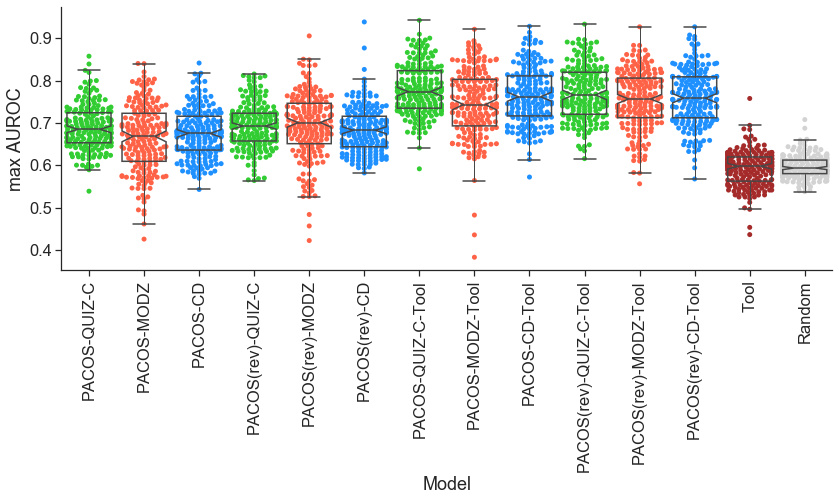

In [5]:
cols = ['limegreen', 'tomato', 'dodgerblue', 'limegreen', 'tomato', 'dodgerblue', 'limegreen', 'tomato', 'dodgerblue', 
        'limegreen', 'tomato', 'dodgerblue', 'brown', 'lightgrey']
fig = plt.figure()
fig.set_size_inches(12, 9)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    # plot swarmplot
    ax = sns.swarmplot(x='Model', y='AUROC', data=all_aurocs_concat_df, zorder=0, palette=cols, alpha=1.0)
    # plot boxplot
    sns.boxplot(x='Model', y='AUROC', data=all_aurocs_concat_df, showcaps=True, notch=True, boxprops={'facecolor':'None'}, showfliers=False, 
                whiskerprops={'linewidth':1}, ax=ax)
    plt.xticks(rotation=90)
    #plt.ylim(0.40, 0.90)
    plt.tight_layout()
    plt.xticks(np.arange(0, 14),  ['PACOS-QUIZ-C', 'PACOS-MODZ', 'PACOS-CD', 'PACOS(rev)-QUIZ-C', 'PACOS(rev)-MODZ', 'PACOS(rev)-CD', 
                                  'PACOS-QUIZ-C-Tool', 'PACOS-MODZ-Tool', 'PACOS-CD-Tool', 
                                  'PACOS(rev)-QUIZ-C-Tool', 'PACOS(rev)-MODZ-Tool', 'PACOS(rev)-CD-Tool',
                                 'Tool', 'Random'])
    sns.despine()
    plt.ylabel('max AUROC')
    plt.savefig('/Users/ardahalu/Desktop/QRZC_final_figures_NEW/AUROC_comparisons_NEW.pdf', format='pdf')
    plt.show()

In [5]:
# -QRZC is significantly higher for PACOS, in forward mode, than both LCB and CD, 
# and significantly higher for PACOS, in reverse mode, than CD (LCB is not significant)
# -QRZC is significantly higher for PACOS/Tool, in both forward and reverse mode, than both LCB and CD.
# Both PACOS and PACOS/Tool are significantly higher than both Tool only and random, bor all three CMap-based networks.
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_rho']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_rho']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_rho']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_rho']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_rho_reverse']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_rho_reverse']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_rho_reverse']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_rho_reverse']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_tool_combined']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_tool_combined']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_tool_combined']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_tool_combined']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_tool_combined_reverse']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_tool_combined_reverse']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_tool_combined_reverse']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_tool_combined_reverse']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'Tool_only']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'Random']['AUROC']))

WilcoxonResult(statistic=6792.0, pvalue=0.0006640335212164206)
WilcoxonResult(statistic=7024.0, pvalue=0.0018852693584101529)
WilcoxonResult(statistic=9067.0, pvalue=0.6179953405129793)
WilcoxonResult(statistic=7551.0, pvalue=0.014903216462922905)
WilcoxonResult(statistic=5184.0, pvalue=4.8279587321171604e-08)
WilcoxonResult(statistic=6794.0, pvalue=0.0006702697045448295)
WilcoxonResult(statistic=6987.0, pvalue=0.001605055220141993)
WilcoxonResult(statistic=7016.0, pvalue=0.001821126684397472)
WilcoxonResult(statistic=8825.0, pvalue=0.419238569640083)


In [7]:
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_rho']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_tool_combined']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_rho']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_tool_combined']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_rho']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_tool_combined']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_rho_reverse']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'QRZC_Spearman_tool_combined_reverse']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_rho_reverse']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'LCB_Spearman_tool_combined_reverse']['AUROC']))
print(st.wilcoxon(all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_rho_reverse']['AUROC'], 
                  all_aurocs_concat_df[all_aurocs_concat_df['Model'] == 'CD_Spearman_tool_combined_reverse']['AUROC']))

WilcoxonResult(statistic=532.0, pvalue=6.459410478447599e-30)
WilcoxonResult(statistic=1885.0, pvalue=4.021444008833354e-22)
WilcoxonResult(statistic=635.0, pvalue=1.911899919005285e-29)
WilcoxonResult(statistic=739.0, pvalue=8.562247538190758e-29)
WilcoxonResult(statistic=3635.0, pvalue=1.0401178901515999e-13)
WilcoxonResult(statistic=1431.0, pvalue=1.179110337575239e-24)


# Comparison with L1000CDS2

In [695]:
import requests
import json

url = 'http://amp.pharm.mssm.edu/L1000CDS2/query'

L1000CDS2_resGeneSet_dict = {}
L1000CDS2_result_df_dict = {}
L1000CDS2_top50_TPoverlap_dict = {}
for geneset_name in tqdm(benchmark_genesets['Geneset_name'].to_numpy(), position=0, leave=True):
    
    geneset_up = set(cgp_updn[geneset_name + '_UP'])
    geneset_dn = set(cgp_updn[geneset_name + '_DN'])   
    
    data = {"upGenes":list(geneset_up), "dnGenes":list(geneset_dn)}
    config = {"aggravate":True, "searchMethod":"geneSet", "share":False, "combination":False, "db-version":"latest"}
    #metadata = [{"key":"Tag","value":"gene-set python example"},{"key":"Cell","value":"PC3"}]
    payload = {"data":data,"config":config}
    headers = {'content-type':'application/json'}
    r = requests.post(url,data=json.dumps(payload),headers=headers)
    resGeneSet = r.json() 
    
    L1000CDS2_resGeneSet_dict[geneset_name] = resGeneSet
    
    pert_names = [resGeneSet['topMeta'][i]['pert_id'].upper() for i in range(len(resGeneSet['topMeta']))]
    top50_inames_df = pd.merge(pd.DataFrame(pert_names), L1000_pert_info, left_on=0, right_on='pert_id', how='left')
    
    L1000CDS2_result_df_dict[geneset_name] = top50_inames_df
    

    
    all_positives = set(alldrugs['Pert_iname']) & set(geneset_pert_iname_dict[geneset_name])
    
    L1000CDS2_top50_TPoverlap_dict[geneset_name] = len(set(top50_inames_df['pert_iname']) & set(all_positives))
    
with open('/Users/ardahalu/Desktop/L1000CDS2_top50_TPoverlap_dict.pickle', 'wb') as handle:
    pickle.dump(L1000CDS2_top50_TPoverlap_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 194/194 [01:49<00:00,  1.77it/s]


In [ ]:
QRZC_top50_TPoverlap_dict = {}
QRZC_top50_TPoverlap_dict_tool = {}
QRZC_top50_TPoverlap_dict_combined = {}
LCB_top50_TPoverlap_dict = {}
LCB_top50_TPoverlap_dict_tool = {}
LCB_top50_TPoverlap_dict_combined = {}
CD_top50_TPoverlap_dict = {}
CD_top50_TPoverlap_dict_tool = {}
CD_top50_TPoverlap_dict_combined = {}

for geneset_name in tqdm(benchmark_genesets['Geneset_name'].to_numpy(), position=0, leave=True):
    
    QUIZC_pacos_tool_merged_df = pd.read_csv(proj_output_path + 'Pathopticon_benchmark/' + 'QUIZ-C_%s_r2.csv' % geneset_name)
    MODZ_pacos_tool_merged_df = pd.read_csv(proj_output_path + 'Pathopticon_benchmark/' + 'MODZ_%s_r2.csv' % geneset_name)
    CD_pacos_tool_merged_df = pd.read_csv(proj_output_path + 'Pathopticon_benchmark/' + 'CD_%s_r2.csv' % geneset_name)
     
    QRZC_ranked_df = QUIZC_pacos_tool_merged_df.sort_values('PACOS_Spearman_rho', ascending=False)  
    QRZC_ranked_df_tool = QUIZC_pacos_tool_merged_df.sort_values('tool_score_imputed', ascending=False)  
    QRZC_ranked_df_combined = QUIZC_pacos_tool_merged_df.sort_values('PACOS_tool_combined', ascending=False)  
    MODZ_ranked_df = MODZ_pacos_tool_merged_df.sort_values('PACOS_Spearman_rho', ascending=False)  
    MODZ_ranked_df_tool = MODZ_pacos_tool_merged_df.sort_values('tool_score_imputed', ascending=False)  
    MODZ_ranked_df_combined = MODZ_pacos_tool_merged_df.sort_values('PACOS_tool_combined', ascending=False)  
    CD_ranked_df = CD_pacos_tool_merged_df.sort_values('PACOS_Spearman_rho', ascending=False)  
    CD_ranked_df_tool = CD_pacos_tool_merged_df.sort_values('tool_score_imputed', ascending=False)  
    CD_ranked_df_combined = CD_pacos_tool_merged_df.sort_values('PACOS_tool_combined', ascending=False)  
 
    geneset_up = set(cgp_updn[geneset_name + '_UP'])
    geneset_dn = set(cgp_updn[geneset_name + '_DN']) 
    
    QUIZC_all_positives = set(QUIZC_alldrugs['Pert_iname']) & set(geneset_pert_iname_dict[geneset_name])
    MODZ_all_positives = set(MODZ_alldrugs['Pert_iname']) & set(geneset_pert_iname_dict[geneset_name])
    CD_all_positives = set(CD_alldrugs['Pert_iname']) & set(geneset_pert_iname_dict[geneset_name])
    
    QUIZC_top50_TPoverlap_dict[geneset_name] = len(set(QUIZC_ranked_df[0:50]['Pert_iname']) & set(QUIZC_all_positives))
    QUIZC_top50_TPoverlap_dict_tool[geneset_name] = len(set(QUIZC_ranked_df_tool[0:50]['Pert_iname']) & set(QUIZC_all_positives))
    QUIZC_top50_TPoverlap_dict_combined[geneset_name] = len(set(QUIZC_ranked_df_combined[0:50]['Pert_iname']) & set(QUIZC_all_positives))
    MODZ_top50_TPoverlap_dict[geneset_name] = len(set(MODZ_ranked_df[0:50]['Pert_iname']) & set(MODZ_all_positives))
    LCB_top50_TPoverlap_dict_tool[geneset_name] = len(set(MODZ_ranked_df_tool[0:50]['Pert_iname']) & set(MODZ_all_positives))
    LCB_top50_TPoverlap_dict_combined[geneset_name] = len(set(MODZ_ranked_df_combined[0:50]['Pert_iname']) & set(MODZ_all_positives))
    CD_top50_TPoverlap_dict[geneset_name] = len(set(CD_ranked_df[0:50]['Pert_iname']) & set(CD_all_positives))
    CD_top50_TPoverlap_dict_tool[geneset_name] = len(set(CD_ranked_df_tool[0:50]['Pert_iname']) & set(CD_all_positives))
    CD_top50_TPoverlap_dict_combined[geneset_name] = len(set(CD_ranked_df_combined[0:50]['Pert_iname']) & set(CD_all_positives))
    
    

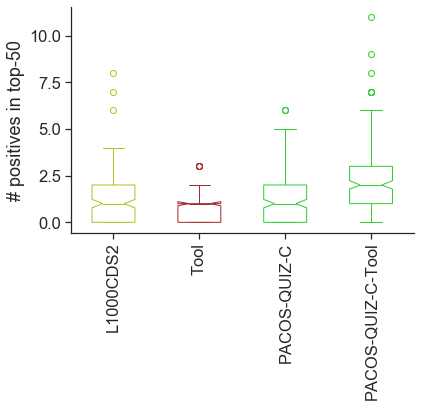

In [227]:
fig = plt.figure()
fig.set_size_inches(6, 6)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):

    box1 = plt.boxplot(L1000CDS2_top50_TPoverlap_dict.values(), widths=0.5, positions=[1], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color='tab:olive')
    plt.setp(box1["boxes"], facecolor='white')
    plt.setp(box1["fliers"], markeredgecolor='tab:olive') 
    
    box2 = plt.boxplot(QRZC_top50_TPoverlap_dict_toolonly.values(), widths=0.5, positions=[2], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color='brown')
    plt.setp(box2["boxes"], facecolor='white')
    plt.setp(box2["fliers"], markeredgecolor='brown')  
    
    box3 = plt.boxplot(QRZC_top50_TPoverlap_dict_pacosonly.values(), widths=0.5, positions=[3], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color='limegreen')
    plt.setp(box3["boxes"], facecolor='white')
    plt.setp(box3["fliers"], markeredgecolor='limegreen')   
    
    box4 = plt.boxplot(QRZC_top50_TPoverlap_dict_comb.values(), widths=0.5, positions=[4], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box4[item], color='limegreen')
    plt.setp(box4["boxes"], facecolor='white')
    plt.setp(box4["fliers"], markeredgecolor='limegreen')   
    
    plt.xticks(np.arange(1, 5),  ['L1000CDS2', 'Tool', 'PACOS-QUIZ-C', 'PACOS-QUIZ-C-Tool'])
    plt.xticks(rotation=90)
    plt.ylabel('# positives in top-50')

    plt.tight_layout()
    sns.despine()
    plt.savefig('/Users/ardahalu/Desktop/QRZC_final_figures/L1000CDS2_vs_QUIZ-C_top50_NEW.pdf', format='pdf')   
    plt.show()

### L1000CDS2 comparison with LCB and CD

### Compare overlap with known drugs between QRZC and L1000CDS2

In [371]:
QRZC_top50_TPoverlap_dict = {}
QRZC_top50_TPoverlap_dict_tool = {}
QRZC_top50_TPoverlap_dict_combined = {}
LCB_top50_TPoverlap_dict = {}
LCB_top50_TPoverlap_dict_tool = {}
LCB_top50_TPoverlap_dict_combined = {}
CD_top50_TPoverlap_dict = {}
CD_top50_TPoverlap_dict_tool = {}
CD_top50_TPoverlap_dict_combined = {}

for geneset_name in tqdm(sorted(list(common_phenotypes)), position=0, leave=True):
    
    temp_QRZC_df = pd.read_csv('/Users/ardahalu/Desktop/QRZC_final_figures/' + 
                                          'Enrichr_GEO_2S_weighted_master_dfs_%s/%s_2S_weighted_master_df_Enrichr_GEO.csv' 
                                     % (model_name, geneset_name))
    temp_LCB_df = pd.read_csv('/Users/ardahalu/Desktop/QRZC_final_figures/' + 
                                          'Enrichr_GEO_2S_weighted_master_dfs_%s_LCB/%s_2S_weighted_master_df_Enrichr_GEO_LCB.csv' 
                                     % (model_name, geneset_name))
    temp_CD_df = pd.read_csv('/Users/ardahalu/Desktop/QRZC_final_figures/' + 
                                          'Enrichr_GEO_2S_weighted_master_dfs_%s_CD/%s_2S_weighted_master_df_Enrichr_GEO_CD.csv' 
                                     % (model_name, geneset_name))
    
    temp_QRZC_ranked_df = temp_QRZC_df.sort_values('Spearman_rho', ascending=False)  
    temp_QRZC_ranked_df_tool = temp_QRZC_df.sort_values('Tool_only', ascending=False)  
    temp_QRZC_ranked_df_combined = temp_QRZC_df.sort_values('Spearman_tool_combined', ascending=False)  
    temp_LCB_ranked_df = temp_LCB_df.sort_values('Spearman_rho', ascending=False)  
    temp_LCB_ranked_df_tool = temp_LCB_df.sort_values('Tool_only', ascending=False)  
    temp_LCB_ranked_df_combined = temp_LCB_df.sort_values('Spearman_tool_combined', ascending=False)  
    temp_CD_ranked_df = temp_CD_df.sort_values('Spearman_rho', ascending=False)  
    temp_CD_ranked_df_tool = temp_CD_df.sort_values('Tool_only', ascending=False)  
    temp_CD_ranked_df_combined = temp_CD_df.sort_values('Spearman_tool_combined', ascending=False)  
 

    ### calculate input S_df
    geneset_up = set(msigdbv7_c2_cgp_updn[geneset_name + '_UP'])
    geneset_dn = set(msigdbv7_c2_cgp_updn[geneset_name + '_DN'])
    
    # getting the direct targets of the input geneset from TTD
    geneset_direct_targets = [TTD_targID_dict[i] for i in list(set(TTD_targID_dict.keys()) & (geneset_dn | geneset_up))]
    temp_TTD_path_drug_target = TTD_drug_target[TTD_drug_target['TargetID'].isin(geneset_direct_targets)]
    temp_TTD_path_drug_CID = TTD_drugs_CID[TTD_drugs_CID['D00AAN'].isin(temp_TTD_path_drug_target['DrugID'])]
    temp_TTD_path_drug_target_CID = pd.merge(temp_TTD_path_drug_target, temp_TTD_path_drug_CID, left_on='DrugID', right_on='D00AAN', how='left')


    # Get the subset of drugs targeting the given pathway above that is within the QRZC drugs by
    # (1) first getting the lookup table between CIDs, InCHI Keys, SMILES and pert_inames of QRZC compounds;
    # (2) then subsetting the drugs targeting the given pathway by the ones that are in QRZC, in terms of their pert_inames.
    # The resulting number of compounds is naturally small since the drugs in QRZC networks are a small subset of all the drugs 
    # in the TTD database.

    temp_TTD_path_drug_target_pert_iname = pd.merge(temp_TTD_path_drug_target_CID, QRZC_cids_inchi_smiles, 
                                                    left_on=1, right_on='pubchem_cid_x', how='left')
    temp_TTD_path_drug_target_pert_iname = temp_TTD_path_drug_target_pert_iname[~pd.isnull(temp_TTD_path_drug_target_pert_iname['Pert_iname'])]
    #print(len(set(temp_TTD_path_drug_target_pert_iname['DrugID'])))
    
    QRZC_all_positives = set(alldrugs['Pert_iname']) & set(temp_TTD_path_drug_target_pert_iname['Pert_iname'])
    LCB_all_positives = set(LCB_alldrugs['Pert_iname']) & set(temp_TTD_path_drug_target_pert_iname['Pert_iname'])
    CD_all_positives = set(CD_alldrugs['Pert_iname']) & set(temp_TTD_path_drug_target_pert_iname['Pert_iname'])
    
    QRZC_top50_TPoverlap_dict[geneset_name] = len(set(temp_QRZC_ranked_df[0:50]['Pert_iname']) & set(QRZC_all_positives))
    QRZC_top50_TPoverlap_dict_tool[geneset_name] = len(set(temp_QRZC_ranked_df_tool[0:50]['Pert_iname']) & set(QRZC_all_positives))
    QRZC_top50_TPoverlap_dict_combined[geneset_name] = len(set(temp_QRZC_ranked_df_combined[0:50]['Pert_iname']) & set(QRZC_all_positives))
    LCB_top50_TPoverlap_dict[geneset_name] = len(set(temp_LCB_ranked_df[0:50]['Pert_iname']) & set(LCB_all_positives))
    LCB_top50_TPoverlap_dict_tool[geneset_name] = len(set(temp_LCB_ranked_df_tool[0:50]['Pert_iname']) & set(LCB_all_positives))
    LCB_top50_TPoverlap_dict_combined[geneset_name] = len(set(temp_LCB_ranked_df_combined[0:50]['Pert_iname']) & set(LCB_all_positives))
    CD_top50_TPoverlap_dict[geneset_name] = len(set(temp_CD_ranked_df[0:50]['Pert_iname']) & set(CD_all_positives))
    CD_top50_TPoverlap_dict_tool[geneset_name] = len(set(temp_CD_ranked_df_tool[0:50]['Pert_iname']) & set(CD_all_positives))
    CD_top50_TPoverlap_dict_combined[geneset_name] = len(set(temp_CD_ranked_df_combined[0:50]['Pert_iname']) & set(CD_all_positives))

100%|██████████| 194/194 [01:16<00:00,  2.54it/s]


In [215]:
L1000CDS2_top50_df_L1000CDS2 = pd.DataFrame(columns=['# Positives in Top-50', 'Model'])
L1000CDS2_top50_df_L1000CDS2['# Positives in Top-50'] = list(L1000CDS2_top50_TPoverlap_dict.values())
L1000CDS2_top50_df_L1000CDS2['Model'] = 'L1000CDS2'
L1000CDS2_top50_df_QRZC = pd.DataFrame(columns=['# Positives in Top-50', 'Model'])
L1000CDS2_top50_df_QRZC['# Positives in Top-50'] = list(QRZC_top50_TPoverlap_dict.values())
L1000CDS2_top50_df_QRZC['Model'] = 'PACOS-QRZC'
L1000CDS2_top50_df_LCB = pd.DataFrame(columns=['# Positives in Top-50', 'Model'])
L1000CDS2_top50_df_LCB['# Positives in Top-50'] = list(LCB_top50_TPoverlap_dict.values())
L1000CDS2_top50_df_LCB['Model'] = 'PACOS-LCB'
L1000CDS2_top50_df_CD = pd.DataFrame(columns=['# Positives in Top-50', 'Model'])
L1000CDS2_top50_df_CD['# Positives in Top-50'] = list(CD_top50_TPoverlap_dict.values())
L1000CDS2_top50_df_CD['Model'] = 'PACOS-CD'
L1000CDS2_top50_df = pd.concat([L1000CDS2_top50_df_L1000CDS2, L1000CDS2_top50_df_QRZC, L1000CDS2_top50_df_LCB, L1000CDS2_top50_df_CD])

#### PACOS only

In [397]:
print(st.wilcoxon(list(L1000CDS2_top50_TPoverlap_dict.values()), list(QRZC_top50_TPoverlap_dict.values())))
print(st.wilcoxon(list(L1000CDS2_top50_TPoverlap_dict.values()), list(LCB_top50_TPoverlap_dict.values())))
print(st.wilcoxon(list(L1000CDS2_top50_TPoverlap_dict.values()), list(CD_top50_TPoverlap_dict.values())))
print(np.mean(list(L1000CDS2_top50_TPoverlap_dict.values())), np.mean(list(QRZC_top50_TPoverlap_dict.values())), 
      np.mean(list(LCB_top50_TPoverlap_dict.values())), np.mean(list(CD_top50_TPoverlap_dict.values())))

WilcoxonResult(statistic=4690.0, pvalue=0.8176470238029013)
WilcoxonResult(statistic=2715.0, pvalue=2.2916331786018416e-06)
WilcoxonResult(statistic=3102.5, pvalue=0.001760823274632971)
1.2268041237113403 1.2577319587628866 1.8041237113402062 1.577319587628866


#### Tool only

In [398]:
print(st.wilcoxon(list(L1000CDS2_top50_TPoverlap_dict.values()), list(QRZC_top50_TPoverlap_dict_tool.values())))
print(st.wilcoxon(list(L1000CDS2_top50_TPoverlap_dict.values()), list(LCB_top50_TPoverlap_dict_tool.values())))
print(st.wilcoxon(list(L1000CDS2_top50_TPoverlap_dict.values()), list(CD_top50_TPoverlap_dict_tool.values())))
print(np.mean(list(L1000CDS2_top50_TPoverlap_dict.values())), np.mean(list(QRZC_top50_TPoverlap_dict_tool.values())), 
      np.mean(list(LCB_top50_TPoverlap_dict_tool.values())), np.mean(list(CD_top50_TPoverlap_dict_tool.values())))

WilcoxonResult(statistic=1908.5, pvalue=4.267913525516923e-07)
WilcoxonResult(statistic=2061.0, pvalue=5.13963758826728e-06)
WilcoxonResult(statistic=1908.5, pvalue=4.267913525516923e-07)
1.2268041237113403 0.6752577319587629 0.7422680412371134 0.6752577319587629


#### PACOS + tool combined

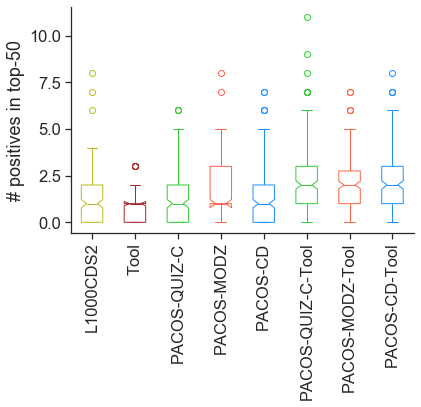

In [225]:
fig = plt.figure()
fig.set_size_inches(6, 6)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):

    box1 = plt.boxplot(L1000CDS2_top50_TPoverlap_dict.values(), widths=0.5, positions=[1], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color='tab:olive')
    plt.setp(box1["boxes"], facecolor='white')
    plt.setp(box1["fliers"], markeredgecolor='tab:olive') 
    
    box2 = plt.boxplot(QRZC_top50_TPoverlap_dict_toolonly.values(), widths=0.5, positions=[2], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color='brown')
    plt.setp(box2["boxes"], facecolor='white')
    plt.setp(box2["fliers"], markeredgecolor='brown') 
    
    box3 = plt.boxplot(QRZC_top50_TPoverlap_dict.values(), widths=0.5, positions=[3], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color='limegreen')
    plt.setp(box3["boxes"], facecolor='white')
    plt.setp(box3["fliers"], markeredgecolor='limegreen')  
    
    box4 = plt.boxplot(LCB_top50_TPoverlap_dict.values(), widths=0.5, positions=[4], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box4[item], color='tomato')
    plt.setp(box4["boxes"], facecolor='white')
    plt.setp(box4["fliers"], markeredgecolor='tomato')   
    
    box5 = plt.boxplot(CD_top50_TPoverlap_dict.values(), widths=0.5, positions=[5], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box5[item], color='dodgerblue')
    plt.setp(box5["boxes"], facecolor='white')
    plt.setp(box5["fliers"], markeredgecolor='dodgerblue') 
    
    box6 = plt.boxplot(QRZC_top50_TPoverlap_dict_combined.values(), widths=0.5, positions=[6], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box6[item], color='limegreen')
    plt.setp(box6["boxes"], facecolor='white')
    plt.setp(box6["fliers"], markeredgecolor='limegreen')  
    
    box7 = plt.boxplot(LCB_top50_TPoverlap_dict_combined.values(), widths=0.5, positions=[7], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box7[item], color='tomato')
    plt.setp(box7["boxes"], facecolor='white')
    plt.setp(box7["fliers"], markeredgecolor='tomato')   
    
    box8 = plt.boxplot(CD_top50_TPoverlap_dict_combined.values(), widths=0.5, positions=[8], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box8[item], color='dodgerblue')
    plt.setp(box8["boxes"], facecolor='white')
    plt.setp(box8["fliers"], markeredgecolor='dodgerblue')   
    
    plt.xticks(np.arange(1, 9),  ['L1000CDS2', 'Tool', 'PACOS-QUIZ-C', 'PACOS-MODZ', 'PACOS-CD', 
                                  'PACOS-QUIZ-C-Tool', 'PACOS-MODZ-Tool', 'PACOS-CD-Tool'])
    plt.xticks(rotation=90)
    plt.ylabel('# positives in top-50')

    plt.tight_layout()
    sns.despine()
    plt.savefig('/Users/ardahalu/Desktop/QRZC_final_figures/L1000CDS2_vs_allmethods_top50_NEW.pdf', format='pdf')   
    plt.show()


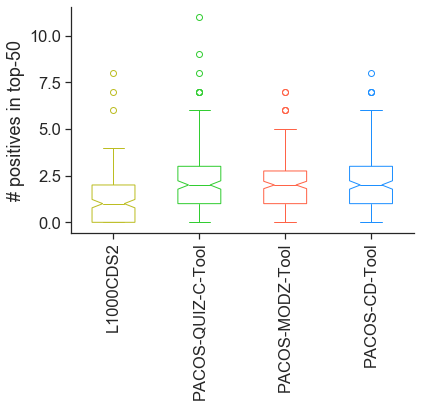

In [226]:
fig = plt.figure()
fig.set_size_inches(6, 6)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):

    box1 = plt.boxplot(L1000CDS2_top50_TPoverlap_dict.values(), widths=0.5, positions=[1], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color='tab:olive')
    plt.setp(box1["boxes"], facecolor='white')
    plt.setp(box1["fliers"], markeredgecolor='tab:olive') 
    
    box2 = plt.boxplot(QRZC_top50_TPoverlap_dict_combined.values(), widths=0.5, positions=[2], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color='limegreen')
    plt.setp(box2["boxes"], facecolor='white')
    plt.setp(box2["fliers"], markeredgecolor='limegreen')  
    
    box3 = plt.boxplot(LCB_top50_TPoverlap_dict_combined.values(), widths=0.5, positions=[3], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color='tomato')
    plt.setp(box3["boxes"], facecolor='white')
    plt.setp(box3["fliers"], markeredgecolor='tomato')   
    
    box4 = plt.boxplot(CD_top50_TPoverlap_dict_combined.values(), widths=0.5, positions=[4], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box4[item], color='dodgerblue')
    plt.setp(box4["boxes"], facecolor='white')
    plt.setp(box4["fliers"], markeredgecolor='dodgerblue')   
    
    plt.xticks(np.arange(1, 5),  ['L1000CDS2', 'PACOS-QUIZ-C-Tool', 'PACOS-MODZ-Tool', 'PACOS-CD-Tool'])
    plt.xticks(rotation=90)
    plt.ylabel('# positives in top-50')

    plt.tight_layout()
    sns.despine()
    plt.savefig('/Users/ardahalu/Desktop/QRZC_final_figures/L1000CDS2_vs_allmethods_combined_top50_NEW.pdf', format='pdf')   
    plt.show()


## Sensitivity analysis

In [690]:
models = ['PACOS_tool_combined_var', 'PACOS_tool_combined_reverse_var']
Nir = 101
method_name = 'MODZ'

for m in models[0:1]:
    
    temp_median_AUROC_arr = np.zeros(Nir)
    temp_median_AUPRC_arr = np.zeros(Nir)
    temp_div_arr = np.zeros(Nir)    
    
    for ir, r in enumerate(tqdm(np.linspace(0, 6, Nir), position=0, leave=True)):
        
        temp_geneset_median_AUROC_df = pd.DataFrame(index=benchmark_genesets['Geneset_name'].to_numpy(), columns=['AUROC'])
        temp_geneset_median_AUPRC_df = pd.DataFrame(index=benchmark_genesets['Geneset_name'].to_numpy(), columns=['AUPRC'])
        QRZC_top50_alldrugs = set()
        
        for geneset_name in benchmark_genesets['Geneset_name'].to_numpy():
                       
            temp_pacos_tool_merged_df = pd.read_csv(proj_output_path + 'Pathopticon_benchmark/' + '%s_%s_r2.csv' % (method_name, geneset_name))

            temp_pacos_tool_merged_df['PACOS_tool_combined_var'] = (r*temp_pacos_tool_merged_df['PACOS_Spearman_rho'] + 
                                                                    temp_pacos_tool_merged_df['tool_score_imputed']) / (r + 1.0)
            temp_pacos_tool_merged_df['PACOS_tool_combined_reverse_var'] = (-1.0*r*temp_pacos_tool_merged_df['PACOS_Spearman_rho'] + 
                                                                            temp_pacos_tool_merged_df['tool_score_imputed']) / (r + 1.0)

            model_sorted = temp_pacos_tool_merged_df.sort_values(m, ascending=False)    
            model_sorted_uniq = model_sorted['Pert_iname'].drop_duplicates()  
                       
            QRZC_top50_alldrugs.update(set(temp_pacos_tool_merged_df.sort_values(m, ascending=False)[0:50]['Pert_iname']))
            
            
            (temp_geneset_median_AUROC_df.at[geneset_name, 'AUROC'], 
             temp_geneset_median_AUPRC_df.at[geneset_name, 'AUPRC']) = AUROC_AUPRC(model_sorted_uniq, 
                                                                                   geneset_pert_iname_dict[geneset_name], 
                                                                                   auc_threshold=5, binsize=1)
                  
        temp_div_arr[ir] = len(QRZC_top50_alldrugs)           
        temp_median_AUROC_arr[ir] = temp_geneset_median_AUROC_df['AUROC'].median()
        temp_median_AUPRC_arr[ir] = temp_geneset_median_AUPRC_df['AUPRC'].median()


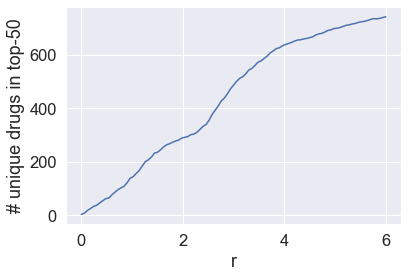

In [805]:
plt.plot(np.linspace(0, 6, Nir), temp_div_arr)
plt.xlabel('r')
plt.ylabel('# unique drugs in top-50')
plt.show()

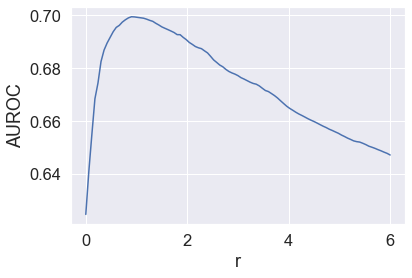

In [806]:
plt.plot(np.linspace(0, 6, Nir), temp_median_AUROC_arr)
plt.xlabel('r')
plt.ylabel('AUROC')
plt.show()

# Circle heat maps

In [ ]:
from matplotlib.collections import PatchCollection

100%|██████████| 194/194 [00:44<00:00,  4.38it/s]


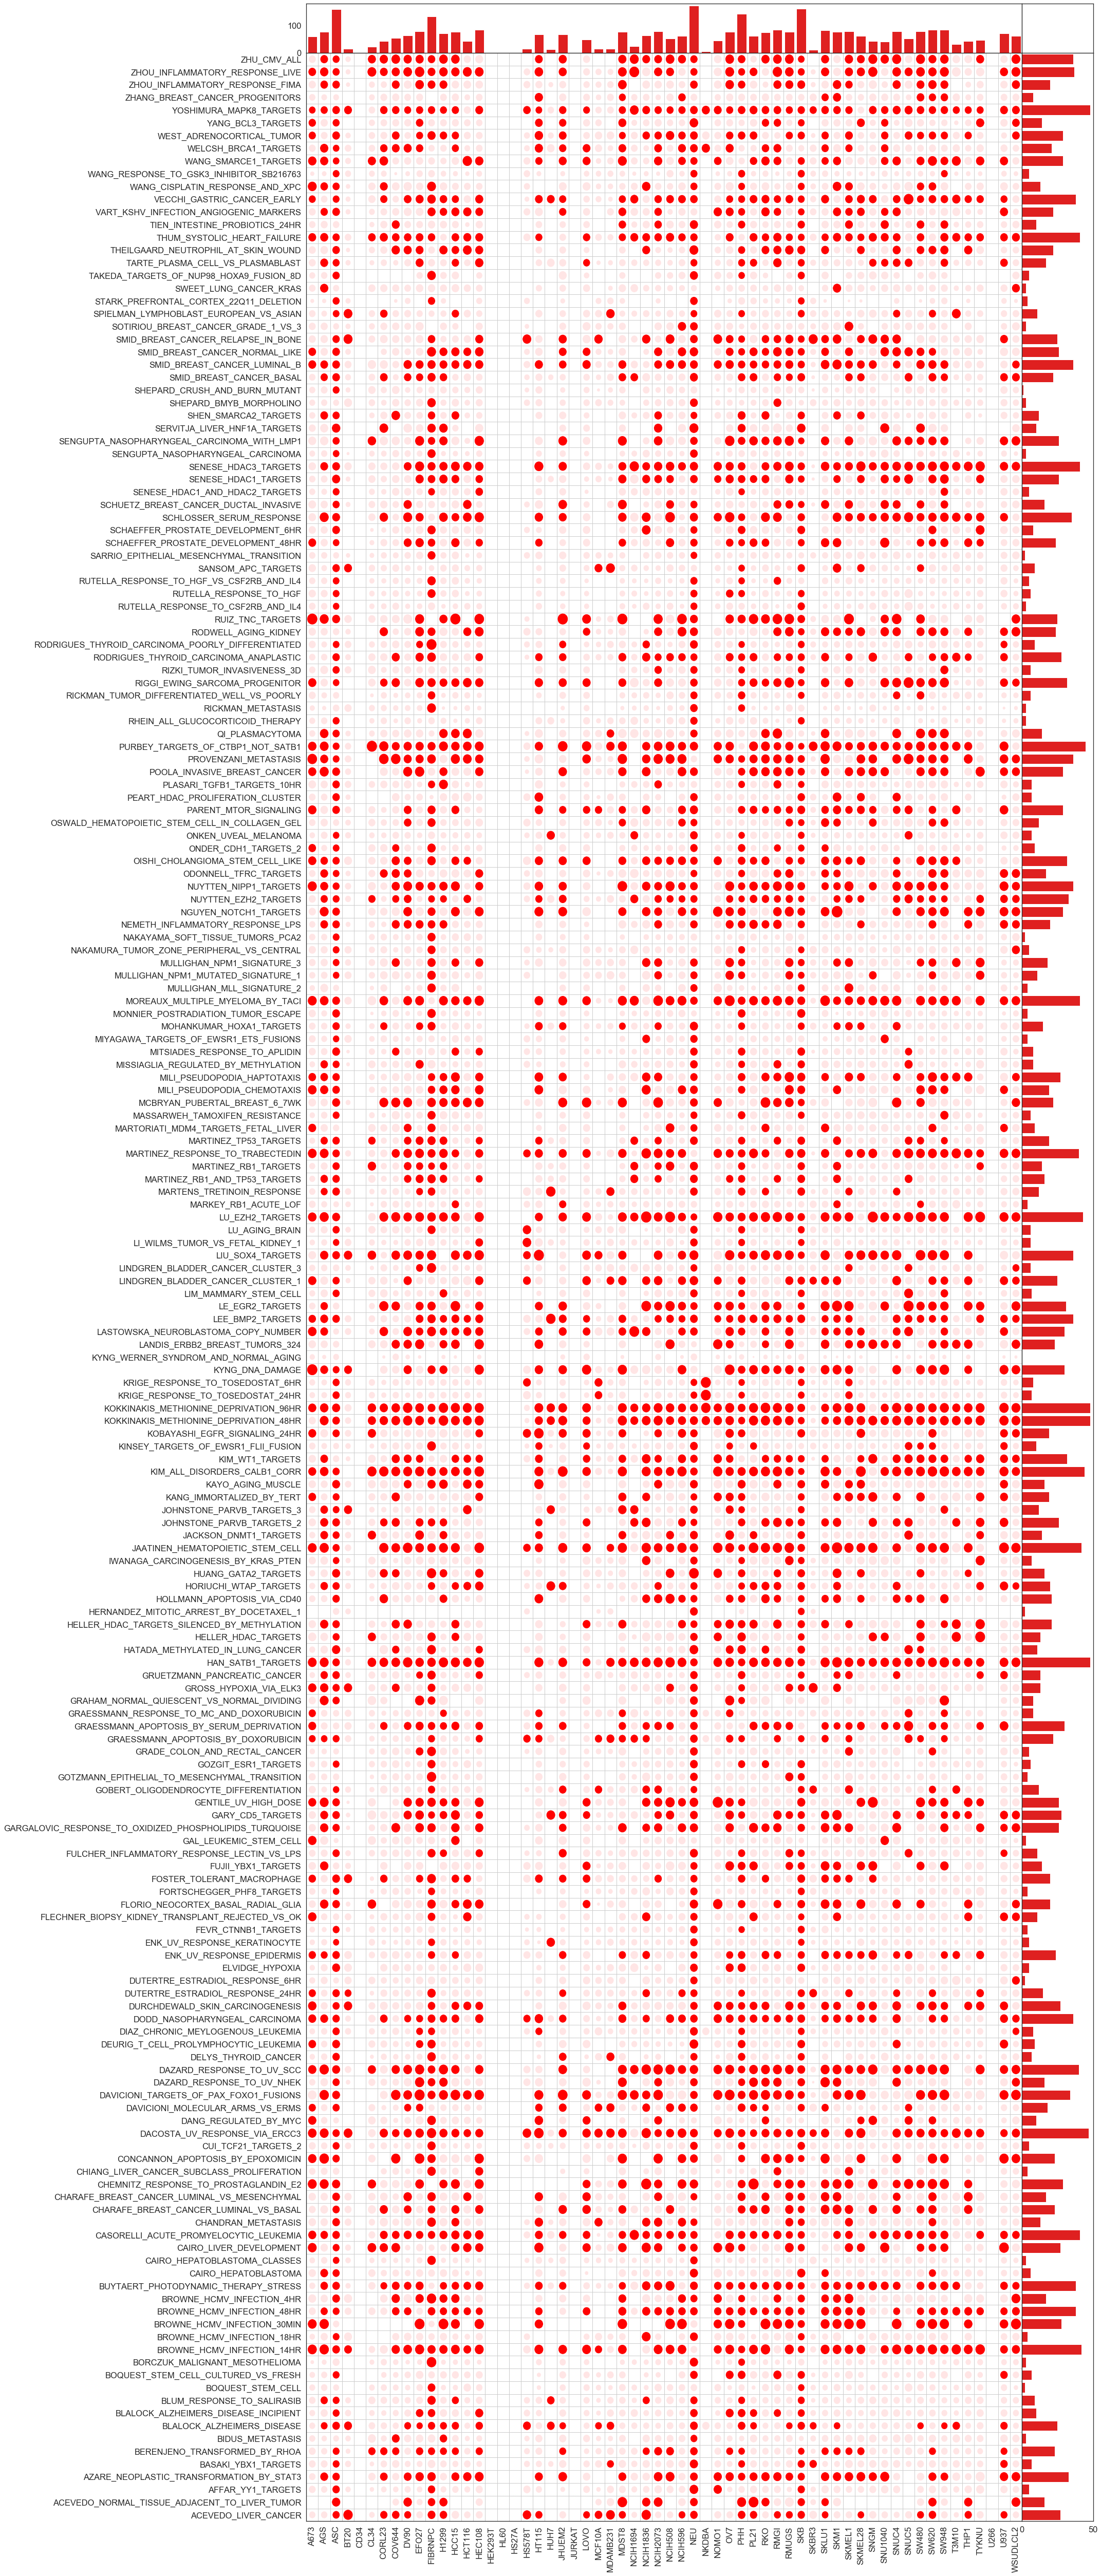

60 54
90.0


In [760]:
method_name = 'QUIZ-C'
m = 'PACOS_tool_combined'

temp_auroc_df = pd.DataFrame(index=benchmark_genesets['Geneset_name'].to_numpy(), columns=QUIZC_allcells['Cell_type'])
temp_auroc_emp_pval_df = pd.DataFrame(index=benchmark_genesets['Geneset_name'].to_numpy(), columns=QUIZC_allcells['Cell_type'])
cols_df = pd.DataFrame(0.0, index=benchmark_genesets['Geneset_name'].to_numpy(), columns=QUIZC_allcells['Cell_type'])

for geneset_name in tqdm(benchmark_genesets['Geneset_name'].to_numpy(), position=0, leave=True):

    temp_nested = pd.read_csv(proj_output_path + 'Pathopticon_benchmark/' + 'Nested_%s_%s_r2.csv' % (method_name, geneset_name))
    for c in temp_nested['Cell_type'].unique():
        temp_auroc_df.at[geneset_name, c] = temp_nested[temp_nested['Cell_type']==c]['%s_AUROC' % m].unique()[0]
        temp_auroc_emp_pval_df.at[geneset_name, c] = temp_nested[temp_nested['Cell_type']==c]['%s_AUROC_emp_pval' % m].unique()[0]
        if temp_auroc_emp_pval_df.at[geneset_name, c] < 0.05: 
            cols_df.at[geneset_name, c] = 1.0

temp_auroc_df_nonan = temp_auroc_df.fillna(0.0)

N = temp_auroc_df.shape[0]
M = temp_auroc_df.shape[1]
ylabels = temp_auroc_df.index.values
xlabels = temp_auroc_df.columns.values

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = temp_auroc_df_nonan.values
c = cols_df.values # color could be based on whether the cell type significant or not based on the randomizations
my_cmap = sns.light_palette('Red', as_cmap=True)

with sns.axes_style("white"):
    
    f, axs = plt.subplots(2, 2, figsize=(30, 70), gridspec_kw=dict(height_ratios=[0.02, 1], width_ratios=[1, 0.1], hspace=0, wspace=0))
    sns.barplot(x=cols_df.columns, y=cols_df.sum(axis=0), ax=axs[0, 0], color='red')
    plt.setp(axs[0, 0].get_xticklabels(), visible=False)
    
    plt.setp(axs[0, 1].get_xticklabels(), visible=False)
    plt.setp(axs[0, 1].get_yticklabels(), visible=False)

    R = s/2
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=c.flatten(), cmap=my_cmap)
    axs[1, 0].add_collection(col)

    axs[1, 0].set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=ylabels)
    axs[1, 0].set_xticks(np.arange(M+1)-0.5, minor=True)
    axs[1, 0].set_yticks(np.arange(N+1)-0.5, minor=True)
    axs[1, 0].set_xticklabels(labels=xlabels, rotation=90)
    axs[1, 0].grid(which='minor')
    

    sns.barplot(x=cols_df.sort_index(ascending=False).sum(axis=1), y=cols_df.sort_index(ascending=False).index, ax=axs[1, 1], color='red')
    plt.setp(axs[1, 1].get_yticklabels(), visible=False)

    #fig.colorbar(col)
    #sns.despine()
    plt.tight_layout()
    #plt.savefig('/Users/ardahalu/Desktop/QRZC_final_figures_NEW/auroc_circle_heatmap_QRZC_%s.pdf' % m, format='pdf')
    plt.show()
    
print(len(cols_df.columns), len(cols_df.sum(axis=0)[cols_df.sum(axis=0)>0.0]))
print(len(cols_df.sum(axis=0)[cols_df.sum(axis=0)>0.0]) / len(cols_df.columns) * 100)